<a href="https://colab.research.google.com/github/olesyamba/Twitter_Parsing_NLP_Sentiment/blob/main/default_twitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Используемый для парсинга пакет snscrape есть в версии разработчика (наиболее актуальная версия библиотеки) и есть дефолтная с открытым доступом. Версия разработчика включает некоторые классные атрибуты в функциях, которые позволяют, например, парсить количество лайков, репостов и ретвиттов на твиттах. Версия разработчика устанавливается только на питон выше 3.8 версии. Сейчас дефолтная версия коллаба уже выше 3.8, но, если будут проблемы, может помочь код в 3 ячейках ниже. (На момент парсинга, коллаб был еще не обновленный, поэтому приходилось изощряться)

In [ ]:
!wget https://github.com/korakot/kora/releases/download/v0.10/py310.sh
!bash ./py310.sh -b -f -p /usr/local
!python -m ipykernel install --name "py310" --user

In [ ]:
!wget -O mini.sh https://repo.anaconda.com/miniconda/Miniconda3-py38_4.8.2-Linux-x86_64.sh
!chmod +x mini.sh
!bash ./mini.sh -b -f -p /usr/local
!conda install -q -y jupyter
!conda install -q -y google-colab -c conda-forge
!python -m ipykernel install --name "py38" --user

In [ ]:
import sys
print("version:", sys.version)

In [ ]:
!pip install nltk
#!pip install --default-time=1000 git+https://github.com/JustAnotherArchivist/snscrape.git
!pip install snscrape
!pip install wordcloud

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import re
from wordcloud import WordCloud, STOPWORDS
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import snscrape.modules.twitter as sntwitter
import nltk

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

Это обобщенная структура парсера, я ее меняла под конкретные задачи и способы хранения данных, можно варьировать способ задавания того, что должно упоминаться в твитте, можно по-разному задавать даты, лучше парсить кусочками, сразу внутри цикла проводить сентимент и сохранять значение в отдельной бд, чтобы не перегружалась оперативная память. Если грамотно составить большой цикл, чтобы оперативка выдерживала циклическую непрерывную работу, то можно ставить парсер на ночь работать. Не очень оптимизированный парсинг и сентимент по 102 компаниям за 6 лет суммарно от недели до двух непрерывной работы занимает (да, твиттов ооочень много, особенно по Apple:).



In [ ]:
#Сюда вводится названия компаний, чтобы спарсить твиты с упоминанием названия (или тикера), можно задавать через список и в цикл ставить
query = input("Query: ")

#As long as the query is valid (not empty or equal to '#')...
if query != '':
    noOfTweet = input("Enter the number of tweets you want to Analyze: ")
    if noOfTweet != '' :
        noOfDays = input("Enter the number of days you want to Scrape Twitter for: ")
        if noOfDays != '':
                #Creating list to append tweet data
                tweets_list = []
                now = dt.date.today()
                now = now.strftime('%Y-%m-%d')
                yesterday = dt.date.today() - dt.timedelta(days = int(noOfDays))
                yesterday = yesterday.strftime('%Y-%m-%d')
                for i,tweet in enumerate(sntwitter.TwitterSearchScraper(query + ' lang:en since:' +  yesterday + ' until:' + now + ' -filter:links -filter:replies').get_items()):
                    if i > int(noOfTweet):
                        break
                    tweets_list.append([tweet.date, tweet.id, tweet.content, tweet.username]) #Посмотрите, какую информацию содержит объект tweet на выходе, много информации про каждый твитт можно собрать (картинка ниже)

                #Creating a dataframe from the tweets list above
                df = pd.DataFrame(tweets_list, columns=['Datetime', 'Tweet Id', 'Text', 'Username'])

                print(df)


Для обобщения задала временной интервал через количество дней для парсинга с текущего момента, можно перезадать по-другому или даже в явном виде вообще задавать внутри первой строчки цикла. Можно внешний цикл делать на последовательный перебор значений параметров now, yesterday, чтобы цикл отдельно по годам пробегал, например. Для этого просто списками now и yesterday задаются и внешний цикл накидывается.

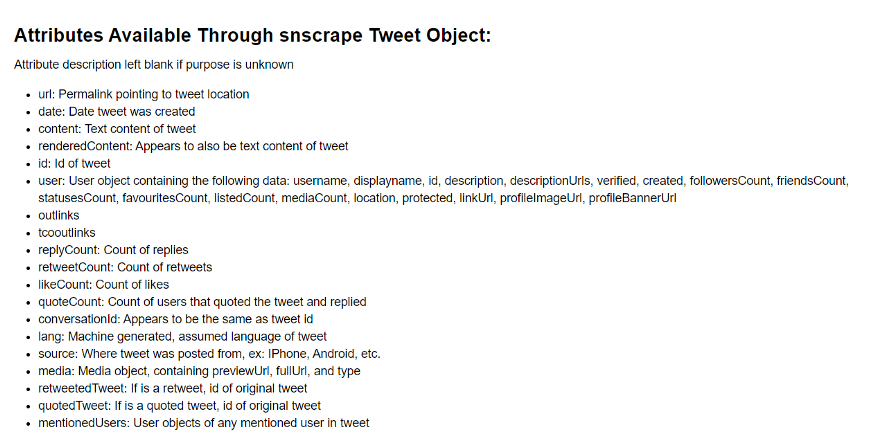

Когда есть датафрейм с отдельными твиттами, первичные текстовые данные нужно отчистить с помощью специальных библиотек и функций (все есть в гугле), лучше с помощью техник NLP. Затем можно проводить сентимент по отдельным твиттам и рассчитывать полярность, которая потом усредняется по году. (Если есть возможность не усреднять, а работать с ежедневными данными, например, это круто, потому что твиттов настолько много, что усреднение по году съедает огромный кусок информации)

In [ ]:

                #Sentiment Analysis
                sent_dict = pd.DataFrame()

                #Iterating over the tweets in the dataframe df
                for tweet in df['Text']:
                    analyzer = SentimentIntensityAnalyzer().polarity_scores(tweet)
                    sent_dict_1 = pd.DataFrame([analyzer])
                    sent_dict = pd.concat([sent_dict, sent_dict_1])




Тоже оставляю базовый и саамый простой способ проведения сентимента, который дополняется в зависимости от задачи. Можно задать пустые списки с позитивными, нейтральными и негативными твиттами, добавлять в них твитты в цикле через условие, что полярность больше или меньше какого-то порогового значения прямо внутри цикла, тогда на выходе из цикла получаются отдельные списки с кластеризированными по полярности твиттами. Можно прямо внутри цикла конкатенировать значение полярности с базой данных, в которой собраны твитты, чтобы на выходе получилась общая бд, но надо оптимизировать работу оперативной памяти или прогонять код на очень мощном пк, меня ограничивали 8 гб оперативной памяти, поэтому приходилось прямо в цикле всю ненужную инфу чистить, а нужную собирать воедино, усреднять по годам и компаниям и хранить в отдельном месте в сжатом виде))

Кроме того можно посмотреть методы кроме polarity_scores, можно не только полярность рассчитывать.

Самый главный момент: в библиотеке snscrape есть аналогичные функции для других социальных сетей, можно парсить данные не только из твиттера.

Советую начинать с одной компании, по ней собрать сначала только твитты за одну неделю, например. Потом дополнить цикл по парсингу доработанным под задачу сентиментом, проверить, что работает. Затем попробовать доработать цикл так, чтобы в нужном отдельном месте собирались итоговые значения, например, полярности. Затем попробовать задавать временной интервал через список. Затем и компании не вводить вручную, а задать через список (да,это все дополнительные циклы). Ну и если необходимо, доработать цикл так, чтобы сразу ну только твитты парсились и обрабатывались. В конце цикла лучше прописать вывод датафрейма или какой-то простой фразы хотя бы, чтобы в процессе реализации видеть, что происходит и сколько уже выгрузилось. Так, если будет появляться какая-то ошибка, не ломающая цикл, но содержательно существенная, ее всегда будет видно и не произойдет печальных оказий, например, что неделю собирались и обрабатывались данные, но, оказывается, пара запятых в ненужном месте перемешала данные и придется делать все заново)))